In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

from matplotlib import pyplot as plt
data = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')

!pip install ipywidgets matplotlib
from matplotlib.widgets import Button

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [2]:
print(data.head())

   label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   
3      4       0       0       0       0       0       0       0       0   
4      0       0       0       0       0       0       0       0       0   

   pixel8  ...  pixel774  pixel775  pixel776  pixel777  pixel778  pixel779  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0         0         0         0   
3       0  ...         0         0         0         0         0         0   
4       0  ...         0         0         0         0         0         0   

   pixel780  pixel781  pixel782  pixel783  
0         0         0         

In [3]:
#Data Preparation
data = np.array(data)
np.random.shuffle(data)
m, n = data.shape
print(m, n)

num_of_test_cases = 10000

#We need dev test sets
data_dev = data[0:num_of_test_cases].T
print(data_dev.shape)#Every columns top is the number and all vales below it are the pixel values
data_x_dev = data_dev[1:n]
data_x_dev = data_x_dev/255.
X = data_x_dev
data_y_dev = data_dev[0]

#We need test test sets
data_test = data[num_of_test_cases : m].T
print(data_test.shape)
data_x_test = data_test[1: n]
data_x_test = data_x_test/255.
data_y_test = data_test[0]

_, m_train = data_x_dev.shape
print(m_train)
print('Y_train array: ', data_y_dev)

42000 785
(785, 10000)
(785, 32000)
10000
Y_train array:  [1 0 9 ... 5 0 6]


In [4]:
#What are we doing in this function? => Setting up all the Weights and biases. How do we do this? By randomly assigning values for the matrixes of W and b
# BUT, W would have to be a list/array of arrays, same for b(set to 0). Their shapes depend on the number of neurons in that layer, the  no. of neurons in the previous layer
# For b: number of neurons in that layer, 1.
# So, we have to use a for loop to make the number of arrays i.e Wi, bi from the users input of the number of layers and neurons per layer.

# Total no. of layers = I/p layer + Hidden layers(From user) + O/p layer
# layers = length of it is the total number of layers and each unit tells us the number of neurons in that layer
# layers 1st VALUE MUST BE 784!!!
def init_parameters(layers, X):
    W = []
    B = []
    for i in range(len(layers)):
        wi = np.random.randn(layers[i], layers[i - 1] if i > 0 else X.shape[0]) * np.sqrt(2 / (layers[i-1] if i > 0 else X.shape[0]))
        bi = np.zeros((layers[i], 1))
        W.append(wi)
        B.append(bi)
    '''
    for i in range(len(W)):
        print(f"W[{i}].shape = {W[i].shape}, B[{i}].shape = {B[i].shape}")
    '''
    return W, B

       
        

In [5]:
def relu(Z):
    return np.maximum(Z, 0)

def leaky_relu(Z, alpha=0.01):
    return np.where(Z > 0, Z, alpha * Z)

def softmax(Z):
    expZ = np.exp(Z - np.max(Z))
    return expZ / np.sum(expZ, axis=0, keepdims=True)

def forward_prop(W, B, layers, X):
    Z = []
    A = [X]

    for i in range(len(layers)):
        #print(W[i].shape)
        z = np.dot(W[i], A[i]) + B[i]  
        Z.append(z)
        if i == len(layers) - 1:
            a = softmax(z)
        else:
            a = leaky_relu(z)
        A.append(a)
    '''
    for i in range(len(Z)):
        print(f"Layer {i}: Z[{i}].shape = {Z[i].shape}, A[{i}].shape = {A[i].shape}")
    ''' 
    return Z, A
    


In [6]:
def relu_deriv(Z):
    return Z > 0

def one_hot(Y, num_classes=10):
    m = Y.size
    one_hot_Y = np.zeros((num_classes, m))
    one_hot_Y[Y, np.arange(m)] = 1
    #one_hot_Y = one_hot_Y.T
    return one_hot_Y

In [7]:
def update_parameters(W, B, alpha, layers, dW, dB):
    for i in reversed(range(len(layers))):
        W[i] = W[i] - (alpha * dW[i])
        B[i] = B[i] - (alpha * dB[i])

    return W, B
    
# m is the number of training examples
# X is the training set's pixels values
# Y is the training set's actual numeric values
def backward_prop(layers, W, Z, A, X, Y, m):
    one_hot_y = one_hot(Y, num_classes=layers[-1])
    dZ = [None] * len(layers)
    dW = [None] * len(layers)
    dB = [None] * len(layers)
    dZ[- 1] = A[- 1] - one_hot_y
    dW[- 1] = (1/m) * (np.dot(dZ[- 1], A[- 2].T))
    dB[-1] = (1/m) * (np.sum(dZ[-1], axis=1, keepdims=True))
    
    for i in range(len(layers)-2, -1, -1):
        dZ[i] = np.dot(W[i+1].T, dZ[i+1]) * (relu_deriv(Z[i]))
        dW[i] = (1/m) * (np.dot(dZ[i], A[i].T if i>0 else X.T))
        dB[i] = (1/m) * (np.sum(dZ[i], axis=1, keepdims=True))
    '''    
    for i in range(len(dW)):
        print(f"dW[{i}].shape = {dW[i].shape}, dB[{i}].shape = {dB[i].shape}")
    '''
        
    return dW, dB

In [8]:
def get_predictions(A2):
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
    print(predictions, Y)
    return np.sum(predictions == Y) / Y.size

def gradient_descent(X, Y, alpha, iterations, layers, lambda_=0.01):
    W, B = init_parameters(layers, X)
    m = X.shape[1]

    for i in range(iterations):
        # Forward pass
        Z, A = forward_prop(W, B, layers, X)
        
        # Compute Loss
        one_hot_Y = one_hot(Y, num_classes=layers[-1])
        loss = -np.sum(one_hot_Y * np.log(A[-1])) / m
        loss += (lambda_ / (2 * m)) * sum([np.sum(np.square(wi)) for wi in W])
        
        # Backward pass
        dW, dB = backward_prop(layers, W, Z, A, X, Y, m)
        
        # Apply L2 regularization
        dW = [dw + (lambda_ / m) * wi for dw, wi in zip(dW, W)]
        
        # Parameter update
        W, B = update_parameters(W, B, alpha, layers, dW, dB)
        
        # Print progress
        if i % 100 == 0: 
            predictions = get_predictions(A[-1])
            acc = get_accuracy(predictions, Y)
            print(f"Iteration {i}, Loss: {loss:.4f}, Accuracy: {acc:.4f}")
        elif iterations-1 == i:
            predictions = get_predictions(A[-1])
            acc = get_accuracy(predictions, Y)
            print(f"Iteration {i}, Loss: {loss:.4f}, Accuracy: {acc:.4f}")            
    
    return W, B


In [9]:
W, B = gradient_descent(
    X=data_x_dev,
    Y=data_y_dev,
    alpha=0.07,
    iterations=1500,
    layers=[data_x_dev.shape[0], 64, 32, 16, 10]
)


[1 1 1 ... 3 1 1] [1 0 9 ... 5 0 6]
Iteration 0, Loss: 2.4865, Accuracy: 0.1248
[1 0 9 ... 5 0 6] [1 0 9 ... 5 0 6]
Iteration 100, Loss: 0.3680, Accuracy: 0.9002
[1 0 9 ... 5 0 6] [1 0 9 ... 5 0 6]
Iteration 200, Loss: 0.2241, Accuracy: 0.9368
[1 0 9 ... 5 0 6] [1 0 9 ... 5 0 6]
Iteration 300, Loss: 0.1491, Accuracy: 0.9610
[1 0 9 ... 5 0 6] [1 0 9 ... 5 0 6]
Iteration 400, Loss: 0.1095, Accuracy: 0.9740
[1 0 9 ... 5 0 6] [1 0 9 ... 5 0 6]
Iteration 500, Loss: 0.0815, Accuracy: 0.9825
[1 0 9 ... 5 0 6] [1 0 9 ... 5 0 6]
Iteration 600, Loss: 0.0606, Accuracy: 0.9883
[1 0 9 ... 5 0 6] [1 0 9 ... 5 0 6]
Iteration 700, Loss: 0.0454, Accuracy: 0.9925
[1 0 9 ... 5 0 6] [1 0 9 ... 5 0 6]
Iteration 800, Loss: 0.0346, Accuracy: 0.9957
[1 0 9 ... 5 0 6] [1 0 9 ... 5 0 6]
Iteration 900, Loss: 0.0267, Accuracy: 0.9972
[1 0 9 ... 5 0 6] [1 0 9 ... 5 0 6]
Iteration 1000, Loss: 0.0210, Accuracy: 0.9984
[1 0 9 ... 5 0 6] [1 0 9 ... 5 0 6]
Iteration 1100, Loss: 0.0168, Accuracy: 0.9991
[1 0 9 ... 5 0 6

In [10]:
layers=[data_x_dev.shape[0], 64, 32, 16, 10]

def make_predictions(X, W, B, layers):
    _, A = forward_prop(W, B, layers, X)
    predictions = get_predictions(A[-1])
    return predictions

def test_prediction(index, W, B):
    current_image = X[:, index, None]
    prediction = make_predictions(X[:, index, None], W, B, layers)
    label = data_y_dev[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Prediction:  [1]
Label:  1


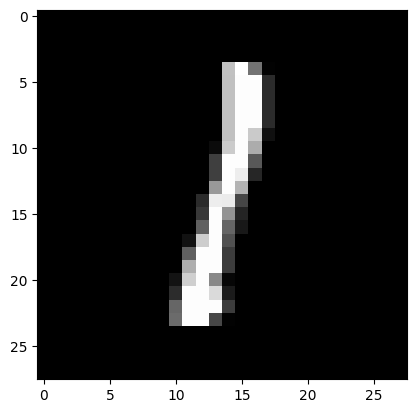

Prediction:  [2]
Label:  2


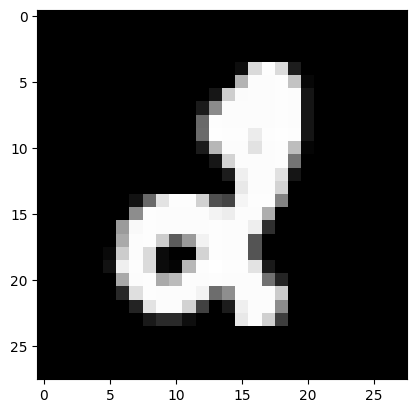

Prediction:  [9]
Label:  9


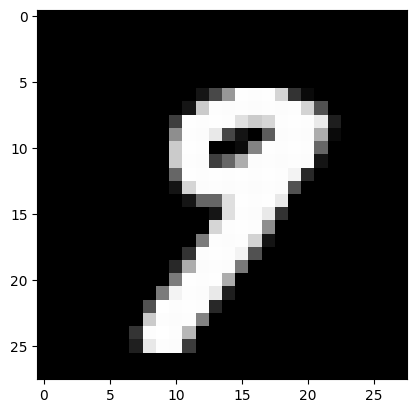

Prediction:  [3]
Label:  3


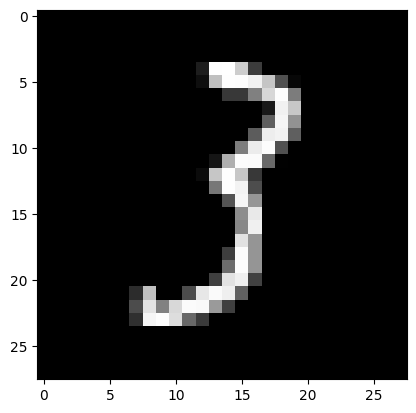

In [11]:
test_prediction(0, W, B)
test_prediction(11, W, B)
test_prediction(2, W, B)
test_prediction(3, W, B)

In [12]:
dev_predictions = make_predictions(data_x_test, W, B, layers)
get_accuracy(dev_predictions, data_y_test)

[9 3 3 ... 7 2 7] [7 3 3 ... 7 2 7]


0.95084375